In [215]:
import torch
from torch import nn

device = "cuda" #if torch.cuda.is_available() else "cpu"
device

'cuda'

In [216]:
import os

train_dir = "/home/uam/HamdahM/training_set"
test_dir = "/home/uam/HamdahM//test_set"
new_test_dir_1 = "/home/uam/HamdahM//test_set_new"
new_test_dir_2 = "/home/uam/HamdahM/augment_test_set/synthetic_test_set"


train_dir, test_dir, new_test_dir_1, new_test_dir_2

('/home/uam/HamdahM/training_set',
 '/home/uam/HamdahM//test_set',
 '/home/uam/HamdahM//test_set_new',
 '/home/uam/HamdahM/augment_test_set/synthetic_test_set')

In [217]:
image_path = "/home/uam/HamdahM"

Random image path: /home/uam/HamdahM/training_set/dogs/dog.2467.jpg
Image class: dogs
Image height: 210
Image width: 359


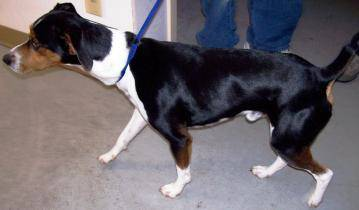

In [218]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


In [219]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [220]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f11e4245480>,
 <torch.utils.data.dataloader.DataLoader at 0x7f11524523e0>)

In [221]:
img, label = next(iter(train_dataloader))

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [222]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)
new_test_data_augmented_1 = datasets.ImageFolder(new_test_dir_1, transform=test_transform)
new_test_data_augmented_2 = datasets.ImageFolder(new_test_dir_2, transform=test_transform)

train_data_augmented, test_data_augmented, new_test_data_augmented_1, new_test_data_augmented_2

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: /home/uam/HamdahM/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /home/uam/HamdahM//test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /home/uam/HamdahM//test_set_new
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of d

In [223]:
BATCH_SIZE = 16
torch.manual_seed(42)
NUM_WORKERS = 4

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS)

new_test_dataloader_augmented_1 = DataLoader(new_test_data_augmented_1, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS)

new_test_dataloader_augmented_2 = DataLoader(new_test_data_augmented_2, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented, new_test_dataloader_augmented_1, new_test_dataloader_augmented_2

(<torch.utils.data.dataloader.DataLoader at 0x7f115246b9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f115246ba60>)

In [225]:
import torch
import torch.nn as nn
from transformers import SegformerImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset


image_processor = SegformerImageProcessor.from_pretrained("microsoft/resnet-18",
                                                     do_resize=False, 
                                                     # since you are already resizing the image in your transformations to the appropriate size (224,224)
                                                     do_recale=False, 
                                                     # this is the division by 255 to normalize the pixel values to [0,1], you are already doing this in your transformations
                                                     do_normalize=False, # let it be true, here the image gets nnormalized to the mean and std of the imagenet dataset
                                                    )
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    

KeyboardInterrupt: 

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               use_adv_style: bool = True, #choose to use advstyle or not
               adv_lr: int = 1.0):
    
    # Setup train loss, adverserial loss and train accuracy values
    train_adv_loss, train_loss, train_acc = 0, 0, 0
    model.train()
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        if use_adv_style:
            mu = X.mean(dim=[2, 3], keepdim=True)
            sig = X.std([2, 3], keepdim=True) + 1e-5
            input_normed = (X - mu) / sig
            input_normed = input_normed.clone().detach()
            # Set learnable style feature and adv optimizer
            adv_mu = mu.clone().detach().requires_grad_(True)
            adv_sig = sig.clone().detach().requires_grad_(True)
            adv_optim = torch.optim.SGD(params=[adv_mu, adv_sig], lr=adv_lr, momentum=0, weight_decay=0)
            # Optimize adversarial style feature
            adv_optim.zero_grad()
            adv_input = input_normed * adv_sig + adv_mu
            adv_input = image_processor(adv_input, return_tensors="pt")

            adv_output = model(**adv_input.to(device))[0]
            adv_loss = loss_fn(adv_output, y)
            (-adv_loss).backward()
            adv_optim.step()
            train_adv_loss += adv_loss.item()
            # Detach adversarial style features to prevent further gradient updates
            adv_mu = adv_mu.detach()
            adv_sig = adv_sig.detach()

        optimizer.zero_grad()
        if use_adv_style:
            adv_input = input_normed * adv_sig + adv_mu
            # rand_ind = torch.randint(0, adv_input.shape[0], (1,))
            # rand_adv_input = adv_input[rand_ind].unsqueeze()
            # inputs = torch.cat((X, rand_adv_input), dim=0)
            # targets = torch.cat((y, y[rand_ind].unsqueeze()), dim=0)
            inputs = torch.cat((X, adv_input), dim=0)
            targets = torch.cat((y, y), dim=0)
        else:
            inputs = X
            targets = y
        
        inputs = image_processor(inputs, return_tensors="pt")

        outputs = model(**inputs.to(device))[0]
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # Calculate and accumulate accuracy metric across all batches
        with torch.no_grad():
            y_pred_class = torch.argmax(outputs, dim=1)
            train_acc += (y_pred_class == targets).float().mean().item()
    train_adv_loss = train_adv_loss / len(dataloader)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_adv_loss, train_acc, train_loss


In [ ]:
def get_accuracy(model: torch.nn.Module,
                X: torch.Tensor,
                y: torch.Tensor,
                loss_fn: torch.nn.Module):

    # Send data to target device
    y =  y.to(device)

    # 1. Forward pass
    inputs = image_processor(X.cpu().numpy(), return_tensors="pt")

    test_pred_logits = model(**inputs.to(device))[0]
    loss = loss_fn(test_pred_logits, y)
    test_loss = loss.item()
    
    # Calculate and accumulate accuracy
    test_pred_labels = test_pred_logits.argmax(dim=1)
    test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    return test_loss, test_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              new_test_dataloader_1: torch.utils.data.DataLoader,
              new_test_dataloader_2: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    test_loss, test_acc, new_test_loss_1, new_test_acc_1, new_test_loss_2, new_test_acc_2 = 0, 0, 0, 0, 0, 0 
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            t_loss, t_acc = get_accuracy(model, X, y, loss_fn)
            test_loss += t_loss
            test_acc += t_acc

        for batch, (X, y) in enumerate(new_test_dataloader_1):
            nt_loss, nt_acc = get_accuracy(model, X, y, loss_fn)
            new_test_loss_1 += nt_loss
            new_test_acc_1 += nt_acc
            
        for batch, (X, y) in enumerate(new_test_dataloader_2):
            nt_loss, nt_acc = get_accuracy(model, X, y, loss_fn)
            new_test_loss_2 += nt_loss
            new_test_acc_2 += nt_acc
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    new_test_loss_1 = new_test_loss_1 / len(new_test_dataloader_1)
    new_test_acc_1 = new_test_acc_1 / len(new_test_dataloader_1)
    new_test_loss_2 = new_test_loss_2 / len(new_test_dataloader_2)
    new_test_acc_2 = new_test_acc_2 / len(new_test_dataloader_2)
    return test_loss, test_acc, new_test_loss_1, new_test_acc_1, new_test_loss_2, new_test_acc_2

In [ ]:
from tqdm.auto import tqdm
from transformers.utils.notebook import NotebookProgressBar


# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          new_test_dataloader_1: torch.utils.data.DataLoader,
          new_test_dataloader_2: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          use_adv_style: bool = True,
          adv_lr: int = 1.0):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "new_test_loss_1": [],
        "new_test_acc_1": [],
        "new_test_loss_2": [],
        "new_test_acc_2": [],
        "adv_loss": []
    }

    for epoch in tqdm(range(epochs)):
        adv_loss, train_acc, train_loss = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc, new_test_loss_1, new_test_acc_1, new_test_loss_2, new_test_acc_2 = test_step(model=model,
            dataloader=test_dataloader,
            new_test_dataloader_1=new_test_dataloader_1,
            new_test_dataloader_2=new_test_dataloader_2,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"new_test_loss_1: {new_test_loss_1:.4f} | "
            f"new_test_acc_1: {new_test_acc_1:.4f} | "
            f"new_test_loss_2: {new_test_loss_2:.4f} | "
            f"new_test_acc_2: {new_test_acc_2:.4f} | "
            f"adv_loss: {adv_loss:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["new_test_loss_1"].append(new_test_loss_1)
        results["new_test_acc_1"].append(new_test_acc_1)
        results["new_test_loss_2"].append(new_test_loss_2)
        results["new_test_acc_2"].append(new_test_acc_2)
        results["adv_loss"].append(adv_loss)


    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


def set_seed(seed: int = 42):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

# Set number of epochs
set_seed(20240220)
NUM_EPOCHS = 30

model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    
model = model.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.classifier.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4) #optimizer changed from Adam to SGD


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=False,
                      adv_lr=0.5)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2905 | train_acc: 0.8780 | test_loss: 0.1131 | test_acc: 0.9616 | new_test_loss_1: 0.2409 | new_test_acc_1: 0.8952 | new_test_loss_2: 0.2439 | new_test_acc_2: 0.8991 | adv_loss: 0.2905
Epoch: 2 | train_loss: 0.2068 | train_acc: 0.9130 | test_loss: 0.1073 | test_acc: 0.9629 | new_test_loss_1: 0.1961 | new_test_acc_1: 0.9201 | new_test_loss_2: 0.2006 | new_test_acc_2: 0.9255 | adv_loss: 0.2068
Epoch: 3 | train_loss: 0.2013 | train_acc: 0.9140 | test_loss: 0.0830 | test_acc: 0.9764 | new_test_loss_1: 0.1692 | new_test_acc_1: 0.9319 | new_test_loss_2: 0.1791 | new_test_acc_2: 0.9290 | adv_loss: 0.2013
Epoch: 4 | train_loss: 0.1897 | train_acc: 0.9189 | test_loss: 0.0761 | test_acc: 0.9739 | new_test_loss_1: 0.1844 | new_test_acc_1: 0.9252 | new_test_loss_2: 0.1991 | new_test_acc_2: 0.9134 | adv_loss: 0.1897
Epoch: 5 | train_loss: 0.1794 | train_acc: 0.9233 | test_loss: 0.0768 | test_acc: 0.9739 | new_test_loss_1: 0.1732 | new_test_acc_1: 0.9316 | new_test_loss_2: 0

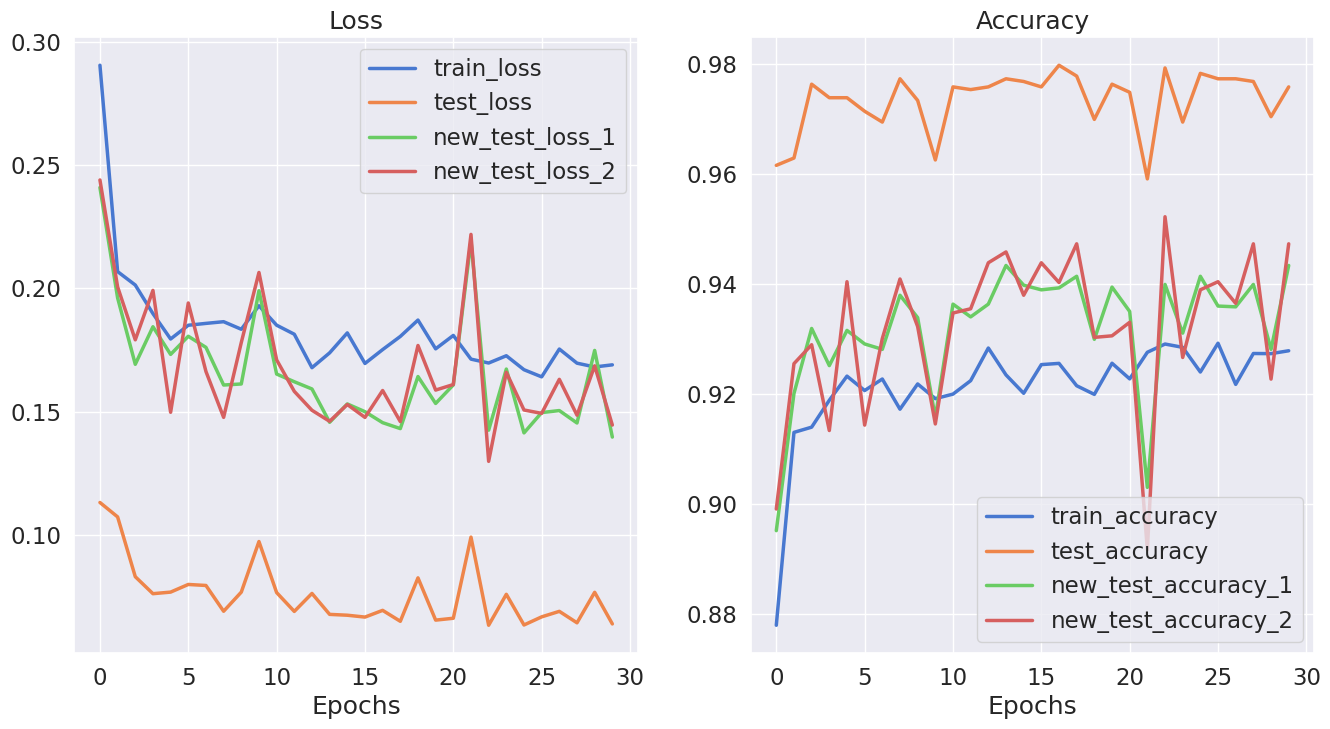

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    new_test_loss_1 = results['new_test_loss_1']
    new_test_loss_2 = results['new_test_loss_2']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    new_test_accuracy_1 = results['new_test_acc_1']
    new_test_accuracy_2 = results['new_test_acc_2']


    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(16, 8))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.plot(epochs, new_test_loss_1, label='new_test_loss_1')
    plt.plot(epochs, new_test_loss_2, label='new_test_loss_2')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.plot(epochs, new_test_accuracy_1, label='new_test_accuracy_1')
    plt.plot(epochs, new_test_accuracy_2, label='new_test_accuracy_2')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plot_loss_curves(model_results)

In [226]:
from typing import List

def plot_results(results: List = [], key:str = "None"):
  
    results = [dict(list(res.items()))[key] for res in results]

    # Figure out how many epochs there were
    epochs = range(len(results[0]))

    plt.figure(figsize=(16, 8))

    # Plot values
    for ix, res in enumerate(results):
        plt.plot(epochs, res, label=f'{ix}')
    plt.title(f'{key}')
    plt.xlabel('Epochs')
    plt.legend()

 Train with adv style (adv_lr = 0.01)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2151 | train_acc: 0.9094 | test_loss: 0.0585 | test_acc: 0.9803 | new_test_loss_1: 0.1121 | new_test_acc_1: 0.9587 | new_test_loss_2: 0.1279 | new_test_acc_2: 0.9605 | adv_loss: 0.2151
Epoch: 2 | train_loss: 0.1308 | train_acc: 0.9455 | test_loss: 0.0549 | test_acc: 0.9797 | new_test_loss_1: 0.1038 | new_test_acc_1: 0.9547 | new_test_loss_2: 0.1072 | new_test_acc_2: 0.9654 | adv_loss: 0.1308
Epoch: 3 | train_loss: 0.1188 | train_acc: 0.9504 | test_loss: 0.0448 | test_acc: 0.9813 | new_test_loss_1: 0.0863 | new_test_acc_1: 0.9665 | new_test_loss_2: 0.0854 | new_test_acc_2: 0.9724 | adv_loss: 0.1188
Epoch: 4 | train_loss: 0.1019 | train_acc: 0.9588 | test_loss: 0.0375 | test_acc: 0.9867 | new_test_loss_1: 0.0862 | new_test_acc_1: 0.9695 | new_test_loss_2: 0.1024 | new_test_acc_2: 0.9636 | adv_loss: 0.1019
Epoch: 5 | train_loss: 0.0875 | train_acc: 0.9668 | test_loss: 0.0416 | test_acc: 0.9852 | new_test_loss_1: 0.0823 | new_test_acc_1: 0.9715 | new_test_loss_2: 0

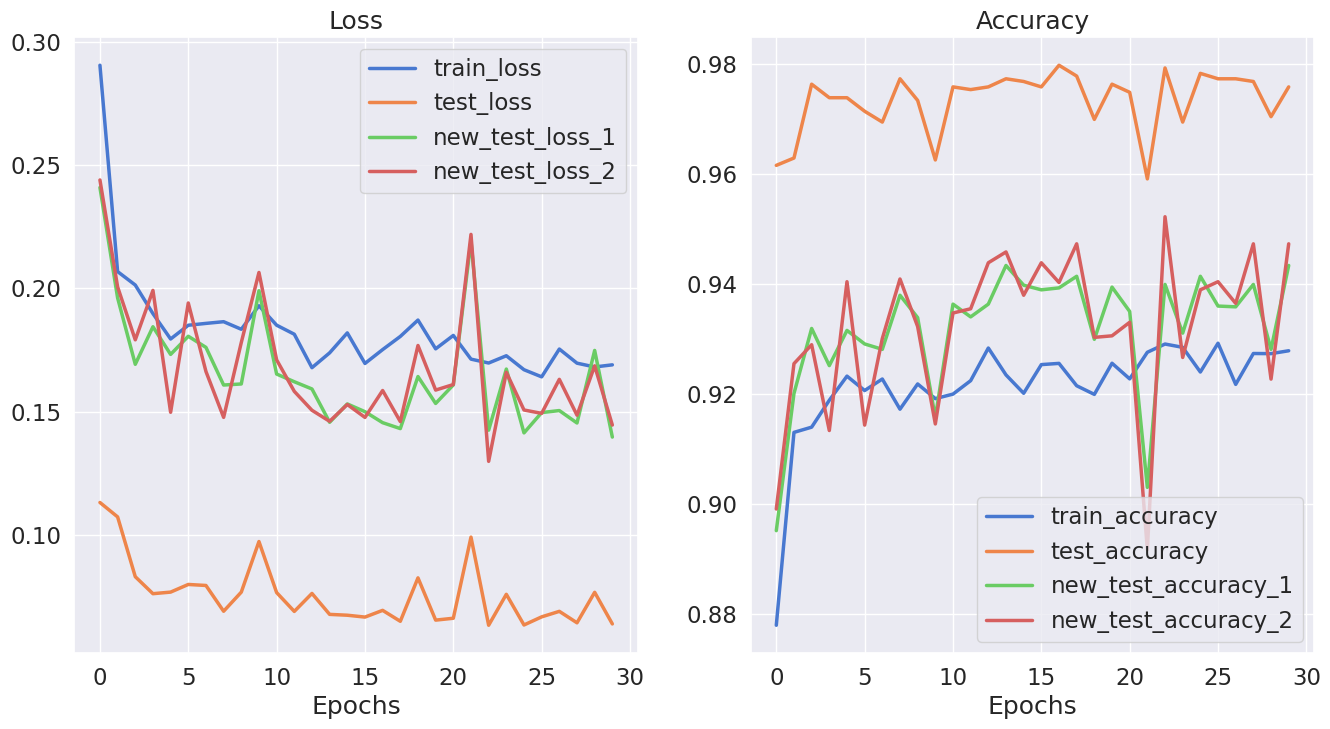

In [228]:
import gc

#del model
#del optimizer
#gc.collect()

set_seed(20240220)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True
                                                     )
                                                                                                                                                          
model = model.to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4)

start_time = timer()

# Train model
ADV_LR = 0.01
model_results_1 = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=True,
                      adv_lr=ADV_LR)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_results_1)

 Train with adv style (adv_lr = 0.1)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2152 | train_acc: 0.9089 | test_loss: 0.0584 | test_acc: 0.9813 | new_test_loss_1: 0.1119 | new_test_acc_1: 0.9572 | new_test_loss_2: 0.1247 | new_test_acc_2: 0.9595 | adv_loss: 0.2152
Epoch: 2 | train_loss: 0.1305 | train_acc: 0.9459 | test_loss: 0.0541 | test_acc: 0.9797 | new_test_loss_1: 0.1064 | new_test_acc_1: 0.9542 | new_test_loss_2: 0.1043 | new_test_acc_2: 0.9664 | adv_loss: 0.1305
Epoch: 3 | train_loss: 0.1186 | train_acc: 0.9513 | test_loss: 0.0449 | test_acc: 0.9818 | new_test_loss_1: 0.0874 | new_test_acc_1: 0.9651 | new_test_loss_2: 0.0847 | new_test_acc_2: 0.9724 | adv_loss: 0.1186
Epoch: 4 | train_loss: 0.1024 | train_acc: 0.9578 | test_loss: 0.0373 | test_acc: 0.9882 | new_test_loss_1: 0.0830 | new_test_acc_1: 0.9719 | new_test_loss_2: 0.1025 | new_test_acc_2: 0.9626 | adv_loss: 0.1024
Epoch: 5 | train_loss: 0.0872 | train_acc: 0.9668 | test_loss: 0.0406 | test_acc: 0.9867 | new_test_loss_1: 0.0825 | new_test_acc_1: 0.9690 | new_test_loss_2: 0

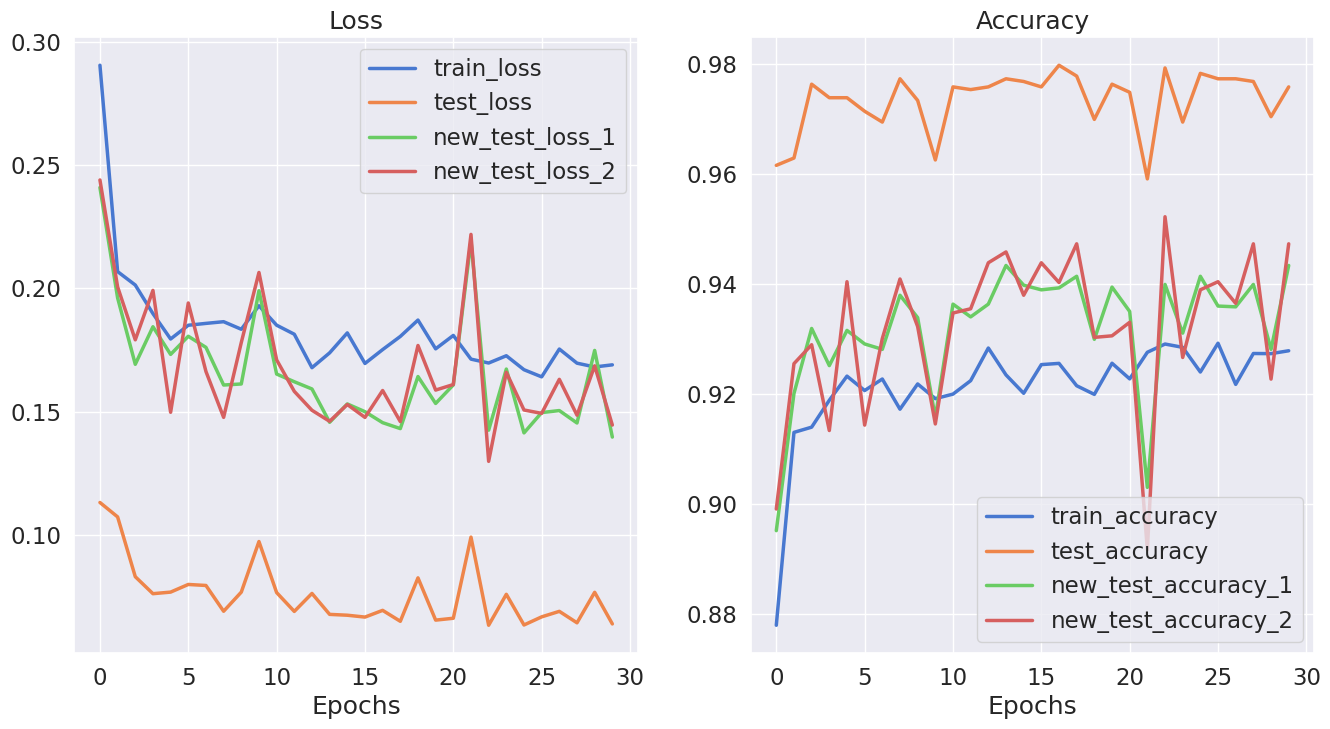

In [229]:
del model
del optimizer
gc.collect()

set_seed(20240220)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4)

start_time = timer()

# Train model
ADV_LR = 0.1
model_results_2 = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=True,
                      adv_lr=ADV_LR)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_results_2)

 Train with adv style (adv_lr = 1.0)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2151 | train_acc: 0.9092 | test_loss: 0.0584 | test_acc: 0.9808 | new_test_loss_1: 0.1119 | new_test_acc_1: 0.9587 | new_test_loss_2: 0.1277 | new_test_acc_2: 0.9595 | adv_loss: 0.2151
Epoch: 2 | train_loss: 0.1310 | train_acc: 0.9460 | test_loss: 0.0535 | test_acc: 0.9813 | new_test_loss_1: 0.1019 | new_test_acc_1: 0.9577 | new_test_loss_2: 0.1061 | new_test_acc_2: 0.9674 | adv_loss: 0.1310
Epoch: 3 | train_loss: 0.1185 | train_acc: 0.9498 | test_loss: 0.0441 | test_acc: 0.9838 | new_test_loss_1: 0.0851 | new_test_acc_1: 0.9660 | new_test_loss_2: 0.0849 | new_test_acc_2: 0.9715 | adv_loss: 0.1185
Epoch: 4 | train_loss: 0.1017 | train_acc: 0.9592 | test_loss: 0.0373 | test_acc: 0.9892 | new_test_loss_1: 0.0854 | new_test_acc_1: 0.9729 | new_test_loss_2: 0.0994 | new_test_acc_2: 0.9651 | adv_loss: 0.1017
Epoch: 5 | train_loss: 0.0874 | train_acc: 0.9657 | test_loss: 0.0403 | test_acc: 0.9867 | new_test_loss_1: 0.0801 | new_test_acc_1: 0.9715 | new_test_loss_2: 0

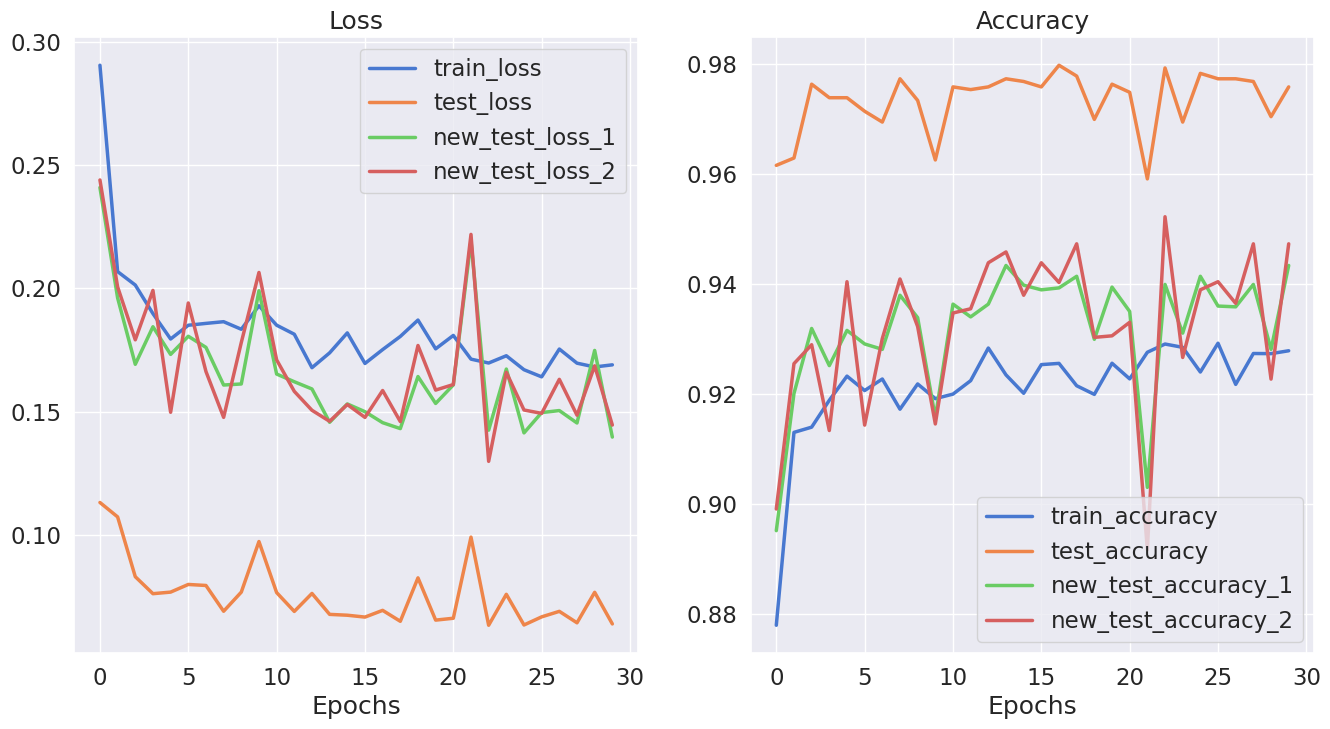

In [230]:
del model
del optimizer
gc.collect()

set_seed(20240220)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4)

start_time = timer()

# Train model
ADV_LR = 1.0
model_results_3 = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=True,
                      adv_lr=ADV_LR)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_results_3)

 Train with adv style (adv_lr = 3.0)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2151 | train_acc: 0.9092 | test_loss: 0.0586 | test_acc: 0.9792 | new_test_loss_1: 0.1121 | new_test_acc_1: 0.9582 | new_test_loss_2: 0.1282 | new_test_acc_2: 0.9585 | adv_loss: 0.2151
Epoch: 2 | train_loss: 0.1306 | train_acc: 0.9454 | test_loss: 0.0539 | test_acc: 0.9808 | new_test_loss_1: 0.1041 | new_test_acc_1: 0.9562 | new_test_loss_2: 0.1035 | new_test_acc_2: 0.9684 | adv_loss: 0.1306
Epoch: 3 | train_loss: 0.1185 | train_acc: 0.9507 | test_loss: 0.0452 | test_acc: 0.9813 | new_test_loss_1: 0.0874 | new_test_acc_1: 0.9670 | new_test_loss_2: 0.0843 | new_test_acc_2: 0.9729 | adv_loss: 0.1185
Epoch: 4 | train_loss: 0.1030 | train_acc: 0.9586 | test_loss: 0.0384 | test_acc: 0.9882 | new_test_loss_1: 0.0873 | new_test_acc_1: 0.9660 | new_test_loss_2: 0.0925 | new_test_acc_2: 0.9695 | adv_loss: 0.1030
Epoch: 5 | train_loss: 0.0870 | train_acc: 0.9671 | test_loss: 0.0416 | test_acc: 0.9867 | new_test_loss_1: 0.0831 | new_test_acc_1: 0.9695 | new_test_loss_2: 0

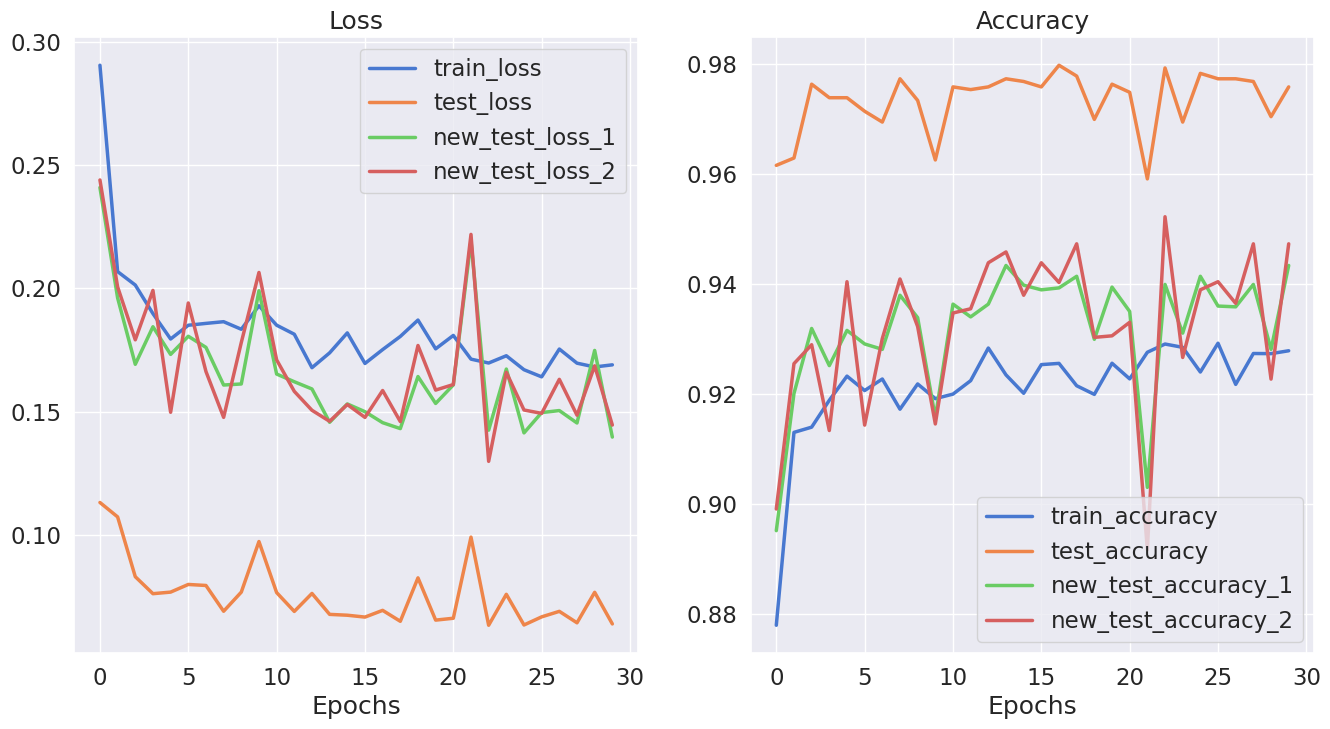

In [231]:
del model
del optimizer
gc.collect()

set_seed(20240220)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4)

start_time = timer()

# Train model
ADV_LR = 3.0
model_results_4 = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=True,
                      adv_lr=ADV_LR)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_results_4)

 Train with adv style (adv_lr = 5.0)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2151 | train_acc: 0.9089 | test_loss: 0.0585 | test_acc: 0.9803 | new_test_loss_1: 0.1120 | new_test_acc_1: 0.9577 | new_test_loss_2: 0.1252 | new_test_acc_2: 0.9600 | adv_loss: 0.2151
Epoch: 2 | train_loss: 0.1305 | train_acc: 0.9456 | test_loss: 0.0542 | test_acc: 0.9808 | new_test_loss_1: 0.1052 | new_test_acc_1: 0.9547 | new_test_loss_2: 0.1072 | new_test_acc_2: 0.9644 | adv_loss: 0.1305
Epoch: 3 | train_loss: 0.1186 | train_acc: 0.9513 | test_loss: 0.0446 | test_acc: 0.9818 | new_test_loss_1: 0.0882 | new_test_acc_1: 0.9656 | new_test_loss_2: 0.0857 | new_test_acc_2: 0.9715 | adv_loss: 0.1186
Epoch: 4 | train_loss: 0.1024 | train_acc: 0.9592 | test_loss: 0.0377 | test_acc: 0.9882 | new_test_loss_1: 0.0864 | new_test_acc_1: 0.9695 | new_test_loss_2: 0.0980 | new_test_acc_2: 0.9660 | adv_loss: 0.1024
Epoch: 5 | train_loss: 0.0877 | train_acc: 0.9673 | test_loss: 0.0417 | test_acc: 0.9852 | new_test_loss_1: 0.0870 | new_test_acc_1: 0.9685 | new_test_loss_2: 0

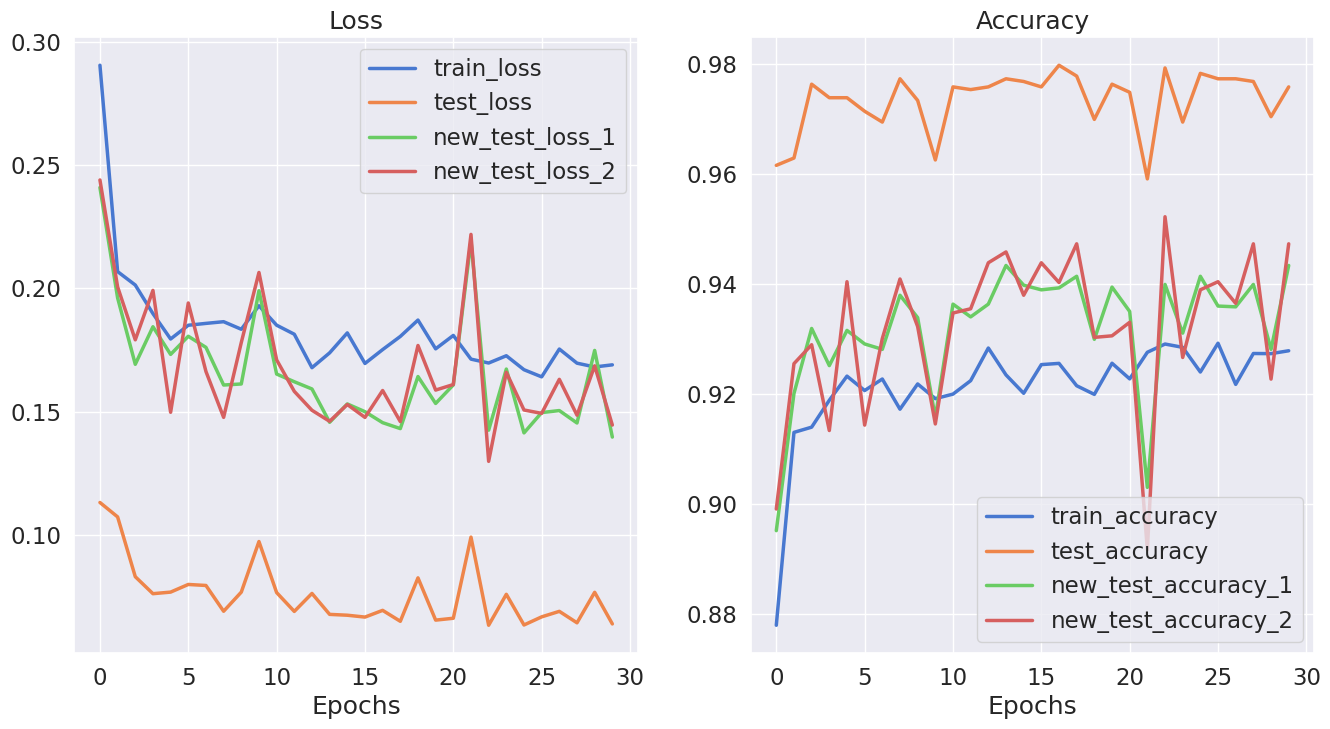

In [232]:
del model
del optimizer
gc.collect()

set_seed(20240220)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4)

start_time = timer()

# Train model
ADV_LR = 5.0
model_results_5 = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=True,
                      adv_lr=ADV_LR)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_results_5)

 Train with adv style (adv_lr = 10.0)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([2, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2152 | train_acc: 0.9093 | test_loss: 0.0587 | test_acc: 0.9803 | new_test_loss_1: 0.1120 | new_test_acc_1: 0.9577 | new_test_loss_2: 0.1271 | new_test_acc_2: 0.9600 | adv_loss: 0.2152
Epoch: 2 | train_loss: 0.1306 | train_acc: 0.9460 | test_loss: 0.0539 | test_acc: 0.9818 | new_test_loss_1: 0.1042 | new_test_acc_1: 0.9562 | new_test_loss_2: 0.1049 | new_test_acc_2: 0.9669 | adv_loss: 0.1306
Epoch: 3 | train_loss: 0.1191 | train_acc: 0.9509 | test_loss: 0.0448 | test_acc: 0.9818 | new_test_loss_1: 0.0873 | new_test_acc_1: 0.9656 | new_test_loss_2: 0.0844 | new_test_acc_2: 0.9719 | adv_loss: 0.1191
Epoch: 4 | train_loss: 0.1023 | train_acc: 0.9588 | test_loss: 0.0375 | test_acc: 0.9867 | new_test_loss_1: 0.0873 | new_test_acc_1: 0.9705 | new_test_loss_2: 0.0999 | new_test_acc_2: 0.9656 | adv_loss: 0.1023
Epoch: 5 | train_loss: 0.0877 | train_acc: 0.9656 | test_loss: 0.0419 | test_acc: 0.9843 | new_test_loss_1: 0.0818 | new_test_acc_1: 0.9715 | new_test_loss_2: 0

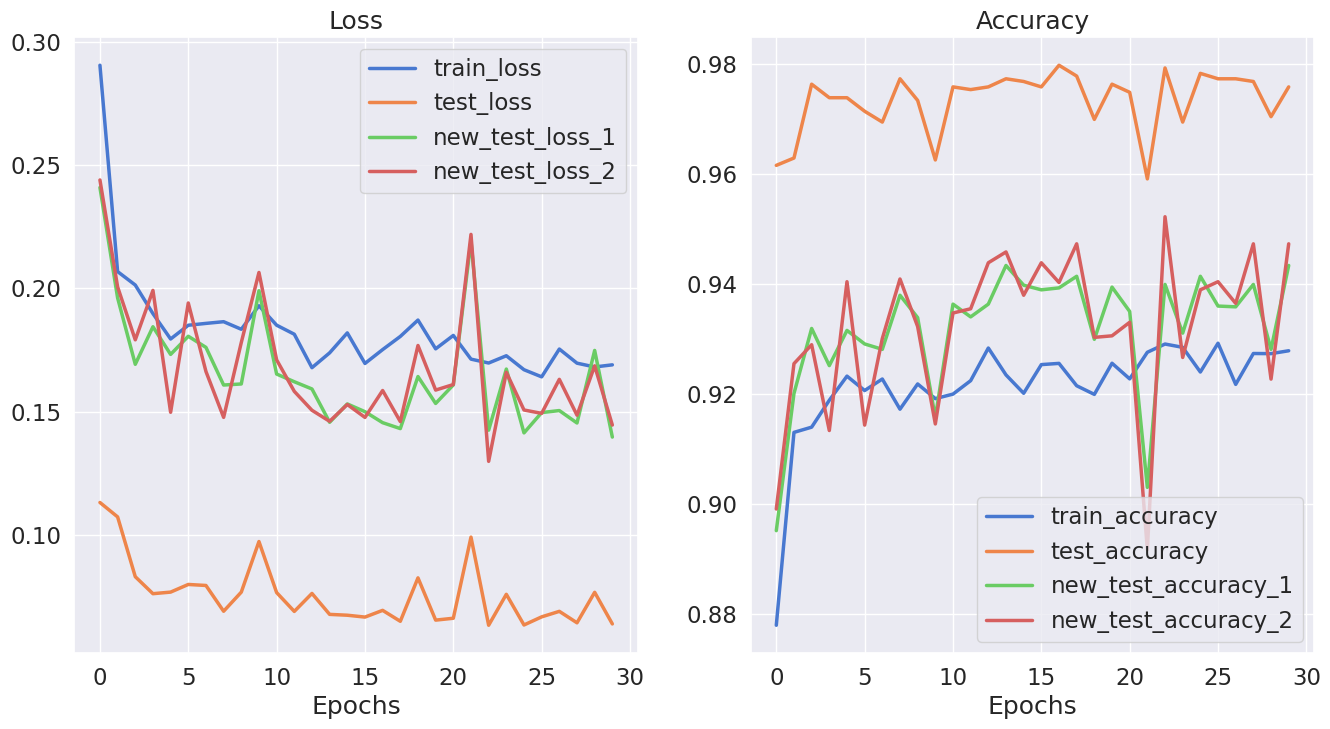

In [233]:
del model
del optimizer
gc.collect()

set_seed(20240220)
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18", 
                                                     num_labels=2, # we only have 2 labels
                                                     ignore_mismatched_sizes=True, 
                                                    )    
model = model.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=3e-4, momentum=0.9, weight_decay=5e-4)

start_time = timer()

# Train model
ADV_LR = 10.0
model_results_6 = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      new_test_dataloader_1=new_test_dataloader_augmented_1,
                      new_test_dataloader_2=new_test_dataloader_augmented_2,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      use_adv_style=True,
                      adv_lr=ADV_LR)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

plot_loss_curves(model_results_6)

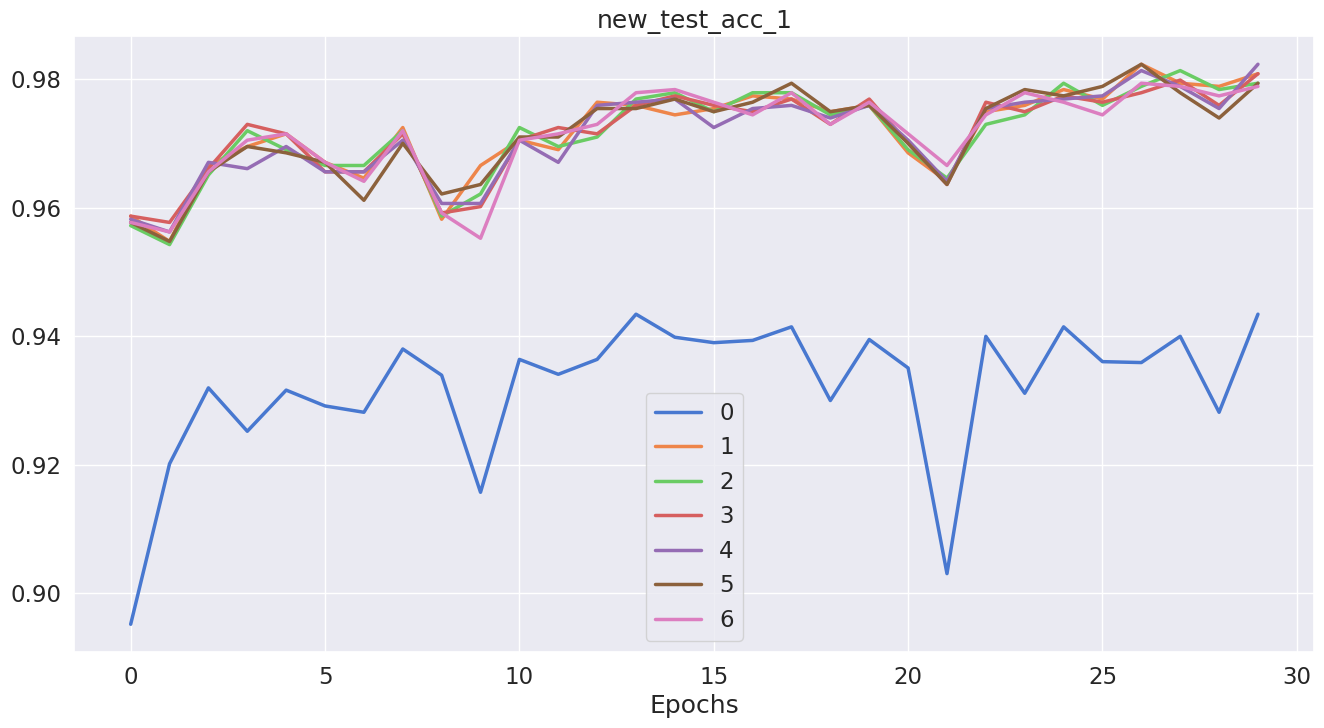

In [234]:
results = [model_results, model_results_1, model_results_2, model_results_3, model_results_4, model_results_5, model_results_6]
plot_results(results, key="new_test_acc_1")

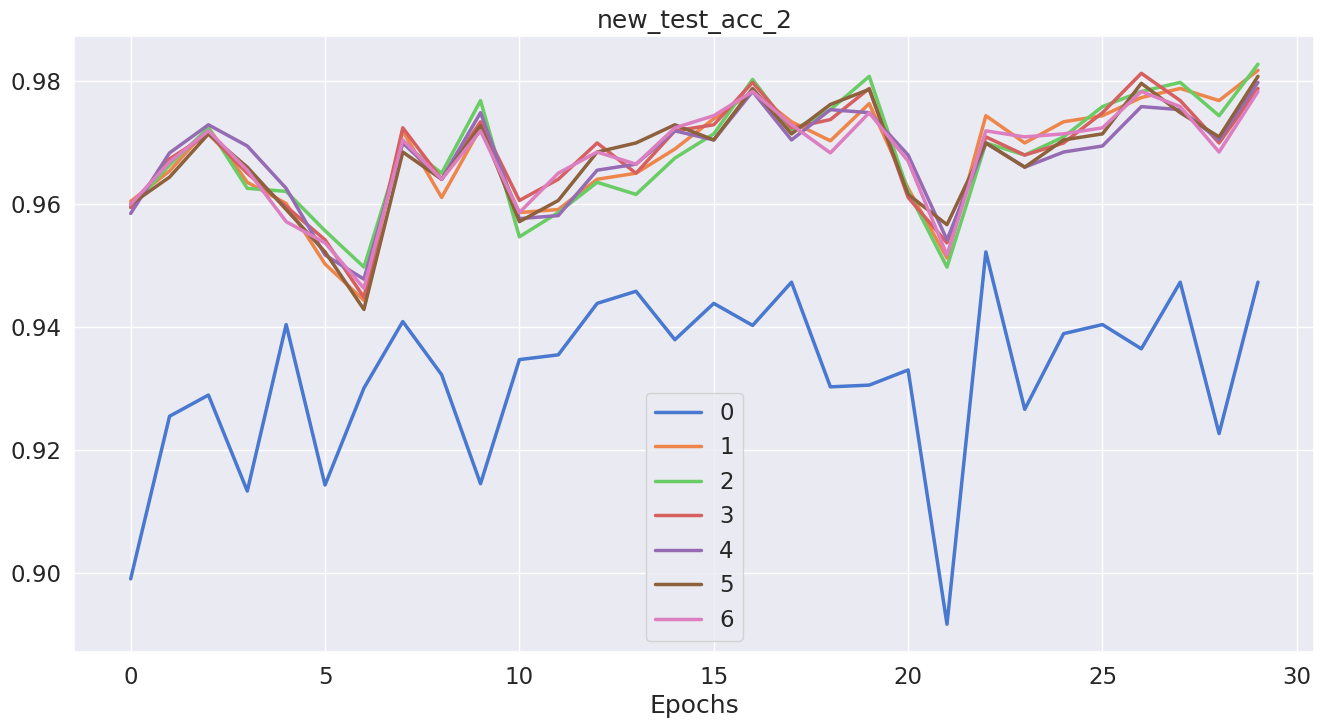

In [235]:
plot_results(results, key="new_test_acc_2")

/home/uam/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


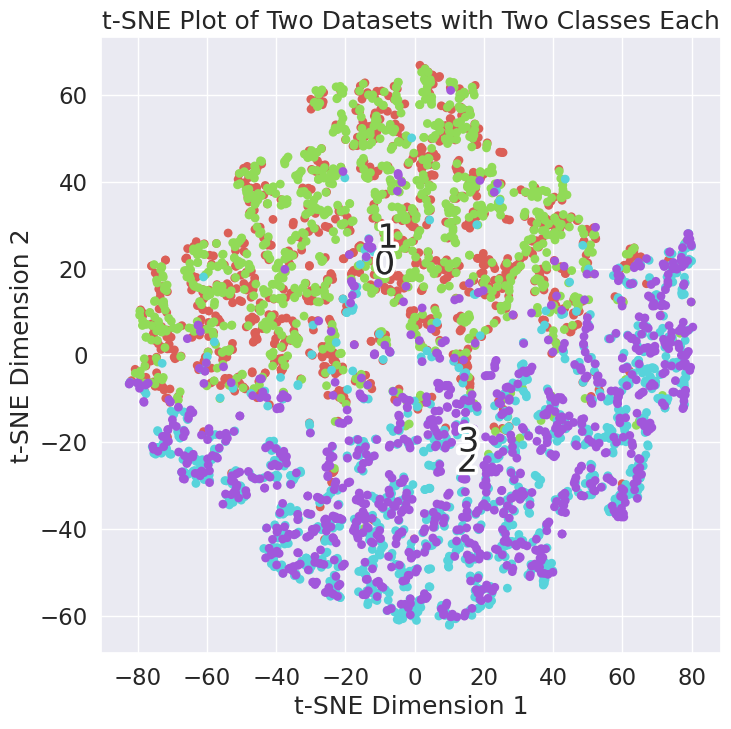

In [236]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE

# So that you won't get the OpenMP related warning
os.environ["OMP_NUM_THREADS"] = "1"

test_dir = "/home/uam/HamdahM/test_set"
aug_test_dir = "/home/uam/HamdahM/augment_test_set/synthetic_test_set"


# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
test_transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor()
    ]
)

dataset_1 = datasets.ImageFolder(test_dir, transform=test_transform)  # usual cats and dogs dataset
dataset_2 = datasets.ImageFolder(new_test_dir_1, transform=test_transform)  # the one I gave you with modified images
dataloader_1 = DataLoader(dataset_1, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)
dataloader_2 = DataLoader(dataset_2, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)


# Assuming you have a DataLoader object named 'dataloader'
# Iterate over the DataLoader to get batches of data
def t_sne(dataloader1: torch.utils.data.DataLoader, dataloader2: torch.utils.data.DataLoader):
    all_X = []
    all_y = []

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader1):
        # This time already is numpy as we don't have to_tensor in the transform
        X = X_batch.numpy()
        # compute the channel-wise mean and standard deviation
        mean = X.mean(axis =(0, 2, 3)) 
        std = X.std(axis =(0, 2, 3))
        y = y_batch.numpy()
        # add mean and std to one list
        mean_std = np.concatenate([mean, std])
        all_X.append(mean_std)
        all_y.append(y)

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader2):
        X = X_batch.numpy()
        mean = X.mean(axis  =(0, 2, 3))
        std = X.std(axis =(0, 2, 3))
        y = y_batch.numpy()
        # We will add 2 to the labels of the second dataset to distinguish them
        y += 2
        mean_std = np.concatenate([mean, std])
        all_X.append(mean_std)
        all_y.append(y)

    all_X = np.vstack(all_X)
    all_y = np.hstack(all_y)


    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=20)
    X_tsne = tsne.fit_transform(all_X)
    # Define colors
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as PathEffects
    import matplotlib
    %matplotlib inline
    
    # We import seaborn to make nice plots.
    import seaborn as sns
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    sns.set_context("notebook", font_scale=1.5,
                    rc={"lines.linewidth": 2.5})
    
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], lw=0, s=40,
                    c=palette[all_y.astype(np.int64)])
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(X_tsne[all_y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    plt.title("t-SNE Plot of Two Datasets with Two Classes Each")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    plt.grid(True)
    plt.show()


t_sne(dataloader_1, dataloader_2)


/home/uam/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/uam/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


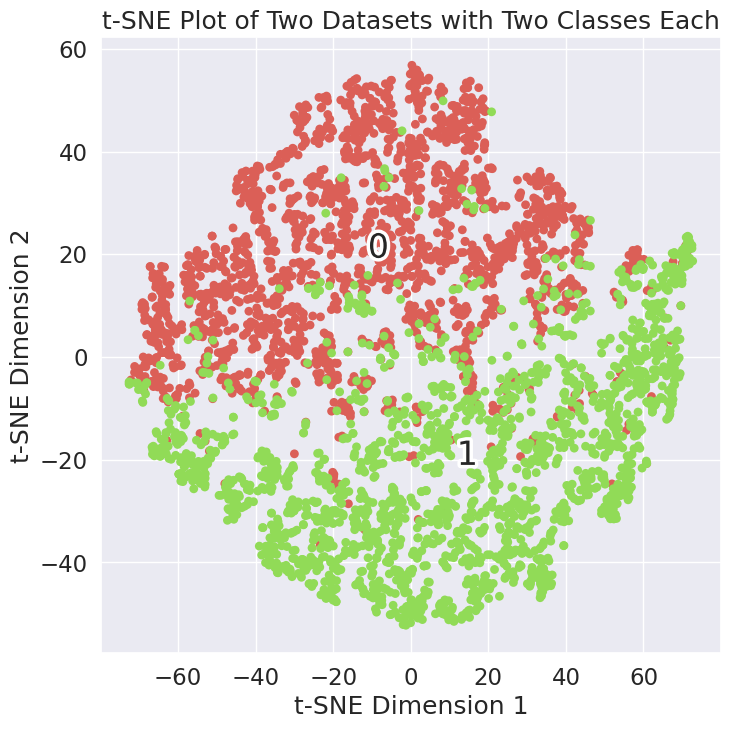

In [237]:
import seaborn as sns
import matplotlib.patheffects as PathEffects
def t_sne(dataloader1: torch.utils.data.DataLoader, dataloader2: torch.utils.data.DataLoader):
    all_X = []
    all_y = []

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader1):
        X = X_batch.numpy()
        # compute the channel-wise mean and standard deviation
        mean = X.mean(axis=(0, 2, 3))
        std = X.std(axis=(0, 2, 3))
        # add mean and std to one list
        mean_std = np.concatenate([mean, std])
        all_X.append(mean_std)
        all_y.append(0)

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader2):
        X = X_batch.numpy()
        mean = X.mean(axis=(0, 2, 3))
        std = X.std(axis=(0, 2, 3))
        mean_std = np.concatenate([mean, std])
        all_X.append(mean_std)
        all_y.append(1)

    all_X = np.vstack(all_X)
    all_y = np.hstack(all_y)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=20240220, perplexity=30)
    X_tsne = tsne.fit_transform(all_X)
    
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 4))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(X_tsne[:,0], X_tsne[:,1], lw=0, s=40,
                    c=palette[all_y.astype(np.int64)])
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(X_tsne[all_y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    plt.title("t-SNE Plot of Two Datasets with Two Classes Each")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()


t_sne(dataloader_1, dataloader_2)